# Evaluation criteria - 

- DB Index: Lower is better.
- Silhouette Score: Higher is better (ranges from -1 to 1).
- Calinski-Harabasz Index: Higher is better.

# Importing Packages

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

In [65]:
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [66]:
customers = pd.read_csv('/kaggle/input/dataset/Data/Customers.csv')
transactions = pd.read_csv('/kaggle/input/dataset/Data/Transactions.csv')
products = pd.read_csv('/kaggle/input/dataset/Data/Products.csv')

In [67]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [68]:
data = pd.merge(transactions, customers, on="CustomerID")
data = pd.merge(data, products, on="ProductID")

In [69]:
data.head(10)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68
5,T00442,C0188,P067,2024-12-26 14:40:03,1,300.68,300.68,Anna Ball,South America,2022-05-17,ComfortLiving Bluetooth Speaker,Electronics,300.68
6,T00490,C0195,P067,2024-11-24 11:49:48,3,902.04,300.68,Jeremy Mclaughlin,South America,2024-09-17,ComfortLiving Bluetooth Speaker,Electronics,300.68
7,T00536,C0008,P067,2024-09-22 06:13:59,1,300.68,300.68,David Li,North America,2024-01-13,ComfortLiving Bluetooth Speaker,Electronics,300.68
8,T00564,C0157,P067,2024-12-07 17:57:40,3,902.04,300.68,Miguel Wong,North America,2024-01-30,ComfortLiving Bluetooth Speaker,Electronics,300.68
9,T00631,C0130,P067,2024-05-14 23:14:59,2,601.36,300.68,Robert Jones,South America,2023-04-19,ComfortLiving Bluetooth Speaker,Electronics,300.68


# Feature Engineering

In [70]:
data['TotalSpent'] = data['Quantity'] * data['Price_x']
customer_data = data.groupby('CustomerID').agg({
    'TotalSpent': 'sum',  # Total spending per customer
    'TransactionID': 'count',  # Number of transactions per customer
    'Region': 'first',  # Region of the customer
}).reset_index()

In [71]:
customer_data.rename(columns={'TransactionID': 'NumTransactions'}, inplace=True)


# Encode categorical variables


In [72]:
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_region = encoder.fit_transform(customer_data[['Region']])
encoded_region = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(['Region']))

In [73]:
customer_data = pd.concat([customer_data, encoded_region], axis=1)

In [74]:
customer_data = customer_data.drop(columns=['CustomerID', 'Region'])

# Normalize numerical features


In [75]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data)
customer_data = pd.DataFrame(scaled_features, columns=customer_data.columns)

# Kmeans Clustering

In [76]:
kmeans = KMeans(n_clusters=5, random_state=42)  
customer_data['Cluster'] = kmeans.fit_predict(customer_data)

In [77]:
db_index = davies_bouldin_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
silhouette = silhouette_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
calinski = calinski_harabasz_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])

In [78]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 0.8727201766443912
Silhouette Score: 0.4489488661211377
Calinski-Harabasz Index: 120.87223271819923


# Visualization 

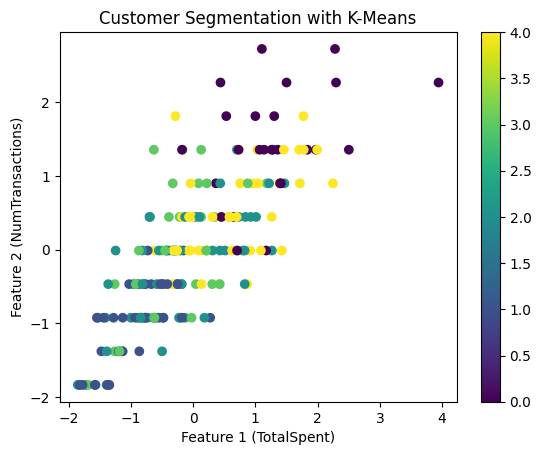

In [79]:
plt.scatter(customer_data.iloc[:, 0], customer_data.iloc[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar()
plt.title("Customer Segmentation with K-Means")
plt.xlabel("Feature 1 (TotalSpent)")
plt.ylabel("Feature 2 (NumTransactions)")
plt.show()

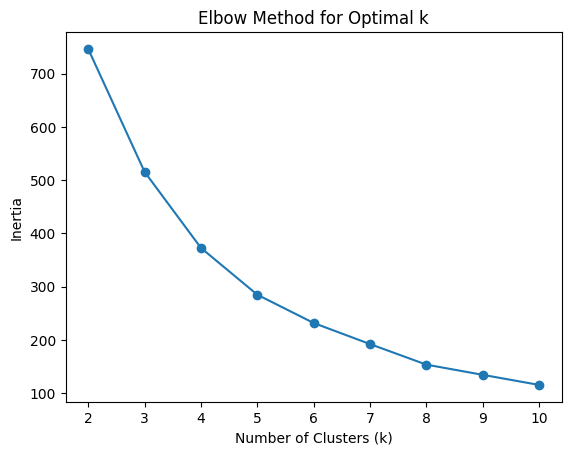

In [80]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data.drop(columns=['Cluster']))
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Improving Model

In [81]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_data.drop(columns=['Cluster']))

    silhouette_avg = silhouette_score(customer_data.drop(columns=['Cluster']), cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}.")

For n_clusters = 2, the average silhouette score is 0.25691894261708625.
For n_clusters = 3, the average silhouette score is 0.4137659892715167.
For n_clusters = 4, the average silhouette score is 0.415019351858285.
For n_clusters = 5, the average silhouette score is 0.4489488661211377.
For n_clusters = 6, the average silhouette score is 0.4548233053963051.
For n_clusters = 7, the average silhouette score is 0.45959924063202817.
For n_clusters = 8, the average silhouette score is 0.47242327409137813.
For n_clusters = 9, the average silhouette score is 0.47743371670986817.
For n_clusters = 10, the average silhouette score is 0.47310322038946717.


> For n_clusters = 9, the average silhouette score is 0.47743371670986817.


In [82]:
# K-Means Clustering
kmeans = KMeans(n_clusters=9, random_state=42)  
customer_data['Cluster'] = kmeans.fit_predict(customer_data)

In [83]:
db_index = davies_bouldin_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
silhouette = silhouette_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
calinski = calinski_harabasz_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 0.7208054317292129
Silhouette Score: 0.4540323062419578
Calinski-Harabasz Index: 139.04521661711445


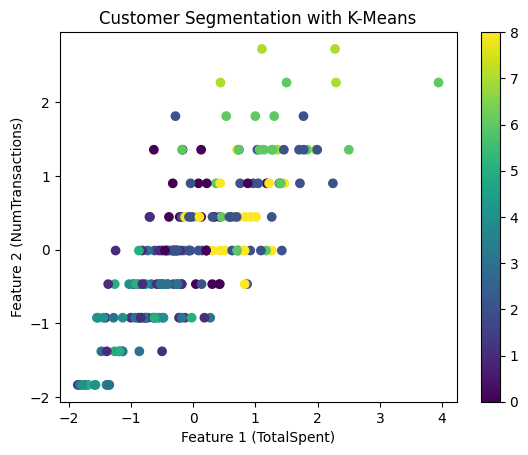

In [84]:
plt.scatter(customer_data.iloc[:, 0], customer_data.iloc[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar()
plt.title("Customer Segmentation with K-Means")
plt.xlabel("Feature 1 (TotalSpent)")
plt.ylabel("Feature 2 (NumTransactions)")
plt.show()

> Accuracy Increased with 9 clusters 

# LetsTry DBSCAN

In [90]:
dbscan = DBSCAN(eps=0.65, min_samples=5)  
customer_data['Cluster'] = dbscan.fit_predict(customer_data)

In [91]:
db_index = davies_bouldin_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
silhouette = silhouette_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])
calinski = calinski_harabasz_score(customer_data.drop(columns=['Cluster']), customer_data['Cluster'])

In [92]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")

DB Index: 1.3979171560137895
Silhouette Score: 0.2936152183158888
Calinski-Harabasz Index: 46.86464168208474


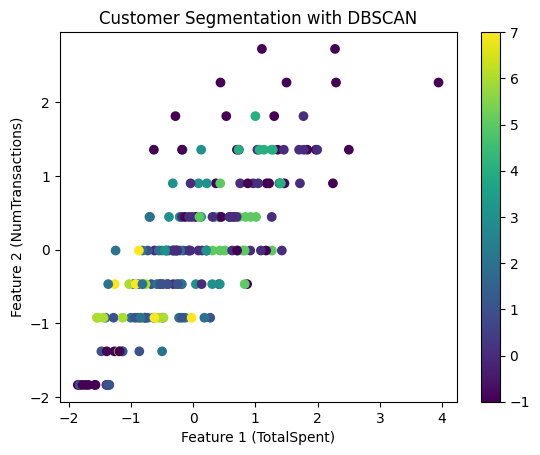

In [89]:
plt.scatter(customer_data.iloc[:, 0], customer_data.iloc[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar()
plt.title("Customer Segmentation with DBSCAN")
plt.xlabel("Feature 1 (TotalSpent)")
plt.ylabel("Feature 2 (NumTransactions)")
plt.show()

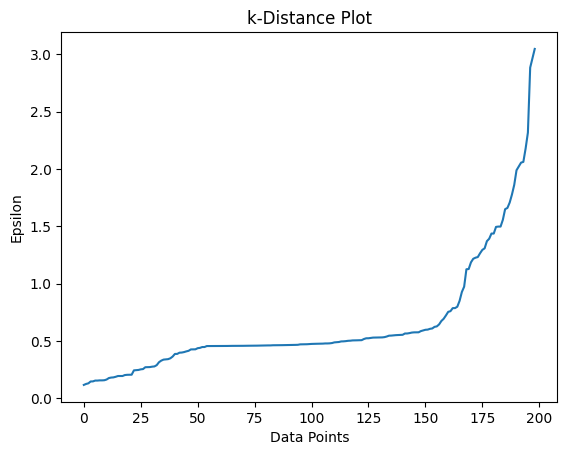

In [88]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(customer_data)
distances, indices = neighbors_fit.kneighbors(customer_data)

distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Epsilon')
plt.title('k-Distance Plot')
plt.show()